In [221]:
import sys
import json

general = {'step_size':'0.001', 'use_road_network':True}
catchment_radius={'bus':'500','subway':'800','rail':'1000'}

params = {
    'general': general,
    'catchment_radius':catchment_radius
    }

default = {'training_folder': '../../scenarios/clermont', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/clermont', 'params': {'general': {'step_size': '0.001', 'use_road_network': True}, 'catchment_radius': {'bus': '500', 'subway': '800', 'rail': '1000'}}}


In [222]:
## identifions les endroits où le réseau routier entre en jeu

In [223]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from typing import Literal
import numba as nb
#num_cores = 1
print('numba threads',nb.config.NUMBA_NUM_THREADS)

on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
io_engine = 'pyogrio' 

numba threads 16


In [224]:
sys.path.insert(0, r'../../') # Add path
from utils import get_epsg, population_to_mesh, get_acf_distances, get_routing_distances

# Folders stucture and params

everything is on S3 (nothing on ECR) so no direct input folder. just scenarios/{scen}/inputs/

In [225]:
argv['training_folder']

'../../scenarios/clermont'

In [226]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/') ## réseau ferré
od_folder =  os.path.join(input_folder,'od/')

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

model_folder = os.path.join(input_folder, 'model/')

In [227]:
zonage_input = gpd.read_file(input_folder + 'communes_zonage_serm.gpkg')
zonage_input.rename(columns={'Population': 'population'}, inplace=True)
zonage_input['density'] = zonage_input['population']/zonage_input.to_crs(epsg='4326').area/10**6
zonage_input = zonage_input[['nom', 'insee_com', 'insee_dep', 'insee_reg', 'population', 'density', 'geometry']]
zonage_input.to_file(input_folder + 'zonage.geojson')

In [228]:
catchment_radius = argv['params']['catchment_radius']
catchment_radius = {k:float(v) for k,v in catchment_radius.items()}
default_catchment_radius = 500

In [229]:
catchment_radius

{'bus': 500.0, 'subway': 800.0, 'rail': 1000.0}

In [230]:
step_size_min = 0.0005
step_size = max(float(argv['params']['general'].get('step_size')), step_size_min)
use_road_network = argv['params']['general'].get('use_road_network') ## param use r_ntw

In [231]:
step_size

0.001

In [232]:
use_road_network

True

# inputs

In [233]:
links = gpd.read_file(pt_folder + 'links.geojson',engine=io_engine) 
nodes = gpd.read_file(pt_folder + 'nodes.geojson',engine=io_engine)
links = links.set_index('index')
nodes = nodes.set_index('index')

Skipping field road_link_list: unsupported OGR type: 5


In [248]:
default_capacity = 60
if 'capacity' not in links.columns:
    links['capacity'] = default_capacity

default_catchment_radius = 500
if 'catchment_radius' not in links.columns:
    links['catchment_radius'] = default_catchment_radius

In [249]:
# find meters CRS
centroid = [*LineString(nodes.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])
crs

32631

In [ ]:
zonage_file = os.path.join(input_folder, 'zonage.geojson')
zonage_file_provided = os.path.isfile(zonage_file)
if zonage_file_provided :
    zonage = gpd.read_file(input_folder + 'zonage.geojson', engine=io_engine)
    if 'population' not in zonage.columns:
        print('no population column defined')
    if 'jobs' not in zonage.columns:
        print('no jobs column defined')
    if 'tourists' not in zonage.columns:
        print('no tourists column defined')
    if zonage.crs != 'EPSG:4326':
        zonage.to_crs(epsg='4326', inplace=True)
        print('CRS was set to 4326')
    zonage['area (km2)'] = zonage.to_crs(crs).area / 10**6
else:
    print('No zonage file in the input folder...')

no jobs column defined
no tourists column defined
CRS was set to 4326


In [251]:
population_provided = ('population' in zonage.columns)
jobs_provided = ('jobs' in zonage.columns)
tourists_provided = ('tourists' in zonage.columns)

In [273]:
base_columns = [x for x in list(zonage.columns) if ((x not in ['population', 'jobs', 'tourists']) and ('density' not in x))]

if population_provided:
    population_file = zonage[base_columns + ['population']]
    population_file['density'] = population_file['population'] / population_file['area (km2)']

if jobs_provided:
    jobs_file = zonage[base_columns + ['jobs']]
    jobs_file['density'] = jobs_file['jobs'] / jobs_file['area (km2)']

if tourists_provided:
    tourists_file = zonage[base_columns + ['tourists']]
    tourists_file['density'] = tourists_file['population'] / tourists_file['area (km2)']

In [237]:
#population_file = os.path.join(input_folder, 'population.geojson')
#population_file_provided = os.path.isfile(population_file)
#if population_file_provided :
#    population = gpd.read_file(population_file, engine=io_engine)
#    if 'index' in population.columns:
#        population = population.set_index('index')
#    else:
#        population.index.name='index'
#    assert 'density' in population.columns, 'need density column. in km2'
#    assert population.crs == 4326, 'population.geojson CRS must be EPSG:4326'
#print('population?',population_file_provided)

# Formation :
 ajouter un paramètre pour utiliser le réseau routier ou non. <br>
 Dans le modèle actuelle, le réseau routier est automatiquement utilisé pour :
 * faire un mesh de la population (affecter les gens aux noeds du réseau)
 * évaluer le stop catchment (la distance de routing est utilisé pour le catchment_radius)

 On pourrait ne pas vouloir utiliser le réseau meme si il est dans le projet! <br>
 TODO: changer rnodes_file_provided pour une combinaison entre un parametre et l'existance du fichier

In [252]:
## road network here
rnodes_file = os.path.join(road_folder, 'road_nodes.geojson')
rnodes_file_provided = os.path.isfile(rnodes_file)
if rnodes_file_provided:
    rnodes = gpd.read_file(os.path.join(road_folder, 'road_nodes.geojson'), engine=io_engine)
    rnodes = rnodes.set_index('index').to_crs(epsg='4326')
    rlinks = gpd.read_file(os.path.join(road_folder, 'road_links.geojson'), engine=io_engine)
    rlinks = rlinks.set_index('index').to_crs(epsg='4326')
print('rnodes?',rnodes_file_provided)

rnodes? True


In [253]:
od_file = os.path.join(od_folder, 'od.geojson')
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    od_test = gpd.read_file(od_file, engine=io_engine)
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))
print('od?',od_file_provided)

od? False


In [254]:
# init results dfs
df_route_id = pd.DataFrame(index=links['route_id'].unique())
df_route_id.index.name = 'route_id'
df_route_id = df_route_id.reset_index()
df_route_id = df_route_id.merge(links[['route_id', 'route_type', 'capacity', 'headway']], on='route_id', how='left')
df_route_id = df_route_id.rename(columns={'capacity': 'veh_capacity (PAX)'})
df_route_id = df_route_id.drop_duplicates()
df_route_id = df_route_id.set_index('route_id')

df_route_type = pd.DataFrame(index=links['route_type'].unique())
df_route_type.index.name='route_type'

In [255]:
# Make sure headway are consistent : one single headway for both way and return
# Otherwise can't calculate KPIs later

df_route_id = df_route_id[~df_route_id.index.duplicated(keep='first')]
route_headway = dict(zip(df_route_id.index, df_route_id['headway']))
links.headway = links.route_id.map(route_headway)

In [256]:
def get_catchment(col='route_id', node_dist=None):
    #get all nodes with col filter
    link = links.groupby(col)[['a','b','route_type']].agg({'a':set,'b':set,'route_type':'first'})
    link['node'] = link.apply(lambda row: row['a'].union(row['b']), axis=1)
    link = link.drop(columns=['a','b'])
    # add catchment radius for the route_type
    link['catchment_radius'] = link['route_type'].apply(lambda x: catchment_radius.get(x,default_catchment_radius))

    col_exist = col == 'route_type' # cannot explode if index == route_type (a column)
    link = link.explode('node').reset_index(drop=col_exist)
    link = node_dist.merge(link, left_on='node_index', right_on='node')
    #filter by distance
    link = link[link['distances'] <= link['catchment_radius']]
    #drop duplicated mesh nodes (we count only one time)
    link = link.drop_duplicates(subset=['mesh_index',col],keep='first')

    return link.groupby(col)['population'].sum().to_dict()

# Population

## Préparation

In [257]:
# find meters CRS
centroid = [*LineString(nodes.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])
crs

32631

## Mesh

In [258]:
## road network here
if not population_provided:
    mesh_pop = gpd.GeoDataFrame(index=[0],data={'zone':'centroid','population':0},geometry=[Point(centroid[0],centroid[1])])
    mesh_pop.index.name = 'index'
    mesh_pop.crs=4326
    if rnodes_file_provided and use_road_network:
        mesh_pop['node_index'] = rnodes.index[0]
elif rnodes_file_provided and use_road_network:
    # use rnodes as mesh_pop.
    print('using road_nodes') ## road network here
    mesh_pop = population_to_mesh(zonage, mesh=rnodes, step=step_size, col='population', fill_missing='closest')
else:
    # create a mesh
    #0.01 = 1km 0.005 = 500m
    mesh_pop = population_to_mesh(zonage, mesh=None, step=step_size, col='population', fill_missing='centroid')

using road_nodes
crs population: EPSG:4326
crs points: EPSG:4326
0 nodes in multiple zones. will be match to a single zone.
13 unfounded zones


In [259]:
mesh_pop.to_file(output_folder + 'population_mesh.geojson',driver='GeoJSON',engine=io_engine)

## Catchment

In [207]:
# find TC nodes to mesh distance

In [260]:
max_dist = max(max(catchment_radius.values()),default_catchment_radius)

In [263]:
## road network here, what to use if not road network?
if rnodes_file_provided: 
    print('using road_nodes')
    node_dist_pop = get_routing_distances(nodes, rnodes, rlinks, mesh_pop, 'length', max_dist)
else:
    node_dist_pop = get_acf_distances(nodes, mesh_pop, crs, max_dist)

using road_nodes


## Metrics

In [264]:
print('num route_id:',len(links['route_id'].unique()))
print('num route_type:',len(links['route_type'].unique()))

num route_id: 1
num route_type: 1


In [265]:
res_route_pop = get_catchment('route_id', node_dist_pop)

df_route_id['catchment population'] = res_route_pop
df_route_id['catchment population'] = df_route_id['catchment population'].fillna(0) 
print(sum([item for key,item in res_route_pop.items()]))

2355.857358833977


In [266]:
res_mode_pop = get_catchment('route_type', node_dist_pop)

df_route_type['catchment population'] = res_mode_pop
df_route_type['catchment population'] = df_route_type['catchment population'].fillna(0) 

print(sum([item for key,item in res_mode_pop.items()]))

2355.857358833977


# Jobs

# Tourists

# frequency

In [179]:
# Suppose that headway is the same in both directions : keep the minimum value
idx = df_route_id.groupby(level=0)['headway'].idxmin()
df_route_id = df_route_id.loc[idx]

df_route_id = df_route_id.rename(columns={'headway': 'headway (s)'})
df_route_id = df_route_id.sort_values('route_type', ascending=False)

KeyError: 'Column not found: headway'

In [158]:
links['frequency'] = 1/links['headway']

In [159]:
res = (links.groupby('route_id')['frequency'].agg('mean')*3600).to_dict()

df_route_id['frequency (veh/hours)'] = res
print(np.nansum([item for key,item in res.items()]))

6.0


In [160]:
res = (links.groupby('route_type')['frequency'].agg('mean')*3600).to_dict()

df_route_type['frequency (veh/hours)'] = res
print(sum([item for key,item in res.items()]))

6.0


In [161]:
link = (links.groupby(['route_id','trip_id'])[['frequency']].agg('mean')*3600)
res = link.reset_index().set_index('route_id')['frequency'].to_dict()
print(np.nansum([item for key,item in res.items()]))

6.0


In [162]:
link = (links.groupby(['route_type','trip_id'])[['frequency']].agg('mean')*3600)
res = link.reset_index().set_index('route_type')['frequency'].to_dict()
print(np.nansum([item for key,item in res.items()]))

6.0


# operational Fleet

In [163]:
def get_fleet(col='route_id'):
    link = links.groupby([col,'trip_id'])[['time','frequency']].agg({'time':'mean','frequency':'mean'})
    link['fleet'] = np.ceil(link['frequency'] * link['time'])
    return link.reset_index().groupby(col)['fleet'].agg('sum').to_dict()


In [164]:
res = get_fleet('route_id')

df_route_id['fleet'] = res
print(sum([item for key,item in res.items()]))

6.0


In [165]:
res = get_fleet('route_type')

df_route_type['fleet'] = res
print(sum([item for key,item in res.items()]))

6.0


# Line Length

In [166]:
def get_length(col='route_id',length_col='length'):
    link = links.groupby([col,'trip_id'])[[length_col]].agg('sum')
    return link.reset_index().groupby(col)[length_col].agg('sum').to_dict()
    

In [167]:
# preparation. if length is NaN, or if shape dist travel exist.

length_col = None
if 'length' in links.columns and length_col == None:
    if len(links[links['length'].isnull()])==0:
        length_col = 'length'
        
if 'shape_dist_traveled' in links.columns and length_col == None:
    if len(links[links['shape_dist_traveled'].isnull()])==0:
        length_col = 'shape_dist_traveled'

if length_col == None:
    print('create length from geometry')
    links['length'] = links.to_crs(crs).length
    length_col = 'length'


In [168]:
res = get_length('route_id',length_col)

df_route_id['length (m)'] = res
print(sum([item for key,item in res.items()]))

18305


In [169]:
res = get_length('route_type',length_col)

df_route_type['length (m)'] = res
print(sum([item for key,item in res.items()]))

18305


# Number of station per line

In [170]:
# o-->o-->o-->o and  o<--o<--o<--o
# est-ce que j'ai 8 ou 4 stations ?
# j'ai 4 stations par trip et 4 stations par route (si c'est les memes).
# comment savoir si cest les memes. clustering?
# pour linstant. on prend tous les noeds unique par route_id ou route_type (col='route_id', route_id)
def get_num_station(col='route_id'):
    link = links.groupby(col)[['a','b']].agg({'a':set,'b':set})
    link['node_len'] = link.apply(lambda row: len(row['a'].union(row['b'])), axis=1)
    return link['node_len'].to_dict()


In [171]:
res = get_num_station('route_id')

df_route_id['num station'] = res
print(sum([item for key,item in res.items()]))

2


In [172]:
res = get_num_station('route_type')

df_route_type['num station'] = res
print(sum([item for key,item in res.items()]))

2


# Vehicle revenue KM 

In [173]:
def get_veh_kmh(col='route_id'):
    link = links.groupby([col,'trip_id'])[[length_col,'frequency']].agg({length_col:'sum','frequency':'mean'})
    link['veh_km/h'] = np.ceil(link['frequency'] * link[length_col]) * 3600/1000 #to km/H
    return link.reset_index().groupby(col)['veh_km/h'].agg('sum').to_dict()

In [174]:
res = get_veh_kmh('route_id')

df_route_id['veh.km/h'] = res
print(sum([item for key,item in res.items()]))

111.6


In [175]:
res = get_veh_kmh('route_type')

df_route_type['veh.km/h'] = res
print(sum([item for key,item in res.items()]))

111.6


# Round trip time

In [176]:
def get_round_trip_time(col='route_id'):
    link = links.groupby([col,'trip_id'])[['time']].agg('sum')
    return link.reset_index().groupby(col)['time'].agg('sum').to_dict()
    

In [177]:
res = get_round_trip_time('route_id')

df_route_id['round trip time (s)'] = res
print(sum([item for key,item in res.items()]))

3295


In [178]:
stop_here

NameError: name 'stop_here' is not defined

# export dfs to csv

In [ ]:
# round numbers
for col in ['catchment', 'frequency (veh/hours)','length (m)','veh.km/h','round trip time (s)']:
    df_route_id[col] = df_route_id[col].apply(lambda x :np.round(x,2))
    df_route_id[col] = df_route_id[col].apply(lambda x :np.round(x,2))


In [ ]:
#df_route_id = df_route_id.fillna('null')
#df_route_type = df_route_type.fillna('null')

In [ ]:
df_route_id.to_csv(output_folder+'route_id_metrics.csv')
df_route_id

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h,round trip time (s)
route_id,,,,,,,
Q1,2355.86,6.0,6.0,18305,2,111.6,3295


In [ ]:
df_route_type.to_csv(output_folder+'route_type_metrics.csv')
df_route_type

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h
route_type,,,,,,
quenedi,2355.857359,6.0,6.0,18305,2,111.6


# Formation:

exporter une image (.png) <br>
ex: barplot du catchement pour les route_type

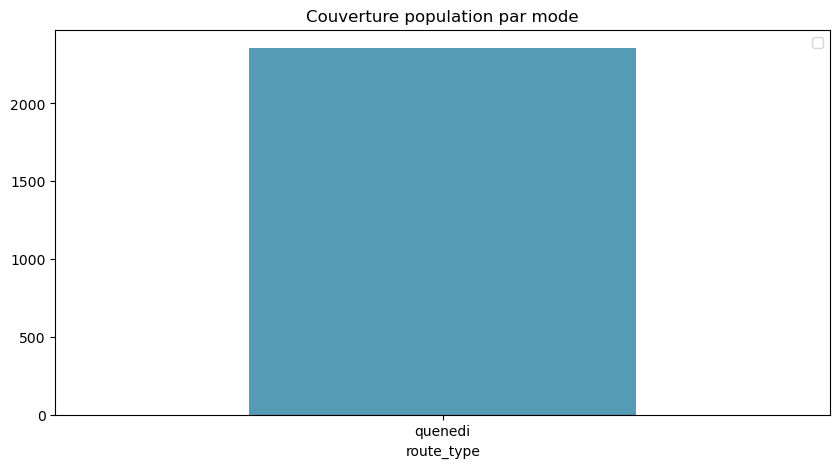

In [ ]:
plot = df_route_type.reset_index().plot(kind='bar', x='route_type', y='catchment', color='#559bb4', rot=0, figsize=[10, 5])
plot.set_title('Couverture population par mode')
plot.set_ylabel('')
plot.set_xlabel("route_type")
plot.legend([])

# geomatic outputs

In [ ]:
#using get catchment. get the catchment radius of each node (get larger one if used by many mode.)
link = links.groupby('route_type')[['a','b','route_type']].agg({'a':set,'b':set,'route_type':'first'})
link['node'] = link.apply(lambda row: row['a'].union(row['b']), axis=1)
link = link.drop(columns=['a','b'])
# add catchment radius for the route_type
link['catchment_radius'] = link['route_type'].apply(lambda x: catchment_radius.get(x,default_catchment_radius))
link = link.explode('node').reset_index(drop=True)
link = link.sort_values('catchment_radius',ascending=False).drop_duplicates('node',keep='first')
link = node_dist.merge(link, left_on='node_index', right_on='node')
link = link[link['distances'] <= link['catchment_radius']]

temp_dict = link.groupby('node_index')['population'].sum().to_dict()
nodes['catchment'] = nodes.index.map(temp_dict.get)

temp_dict = link.groupby('node_index')['catchment_radius'].agg('first').to_dict() 
nodes['catchment_radius'] = nodes.index.map(temp_dict.get)


In [ ]:
nodes.to_file(output_folder+'nodes.geojson',driver='GeoJSON',engine=io_engine)

# test